### Integration of SVM and MVO 
3 factor, 3 turnover, premium of 10% experiments

This notebook only contains exact solves

In [1]:
import gurobipy as gp
from gurobipy import GRB
pth = ''
import sys
import math 
import time

from python.packages import *
from python.svm_mvo import *
from python.analysis_tools import *

%matplotlib inline

%matplotlib inline

## Import Forecasts

forecasts = pd.read_pickle(pth +'cache/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'cache/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'cache/WRDS_ASOF.pkl')
## Import monthly prices
prices = pd.read_pickle(pth + 'cache/PRICES.pkl')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-09


In [1]:
mth = rets.index[0]
mth

NameError: name 'rets' is not defined

In [4]:
#convenient function
sign = lambda a: int((a>0)) - int((a<0))

#preprocessing 
cov_, mean_ = forecasts[mth]
N = len(mean_)
cov = cov_[:N,:N]
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)

#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")

#restrict the wharton research data to the columns of interest
Y = wrds_tics.loc[:,"ROC1":"Vol"] # Y matrix in formulation as per the paper
cols = ['Vol']

Y = wrds_tics.loc[:,cols] # Y matrix in formulation 
Y.Vol = -1*Y.Vol
Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0)) #scale the features
                                 #for the SVM

AssetLim = math.floor(N*0.3)

ret_constr = -1
soft_margin = 10000

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FISV', 'FLS', 'FMC', 'GD', 'GIS', 'GLW', 'GPC', 'GPS', 'GWW', 'HAL', 'HAS', 'HD', 'HES', 'HFC', 'HOG', 'HOLX', 'HON', 'HP', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HSY', 'HUM', 'IBM', 'IDXX', 'IEX', 'IFF', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 'IRM', 

In [5]:
import time
def cb(model, where):
    if where == GRB.Callback.MIPNODE:
        # Get model objective
        obj = model.cbGet(GRB.Callback.MIPNODE_OBJBST)

        # Has objective changed?
        if abs(obj - model._cur_obj) > 1e-8:
            # If so, update incumbent and time
            model._cur_obj = obj
            model._time = time.time()

    # Terminate if objective has not improved in 60s
    if time.time() - model._time > 120:
        model.terminate()

In [6]:
Y

,Vol
tic,
AAPL,-0.040999
ABC,-0.056325
ABMD,-0.071497
ABT,-0.014319
ADBE,-0.081889
...,...
XOM,-0.008261
XRAY,-0.010843
XRX,-0.037908


### Simple Min Variance Portfolio 

In [8]:
MVO = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y, AssetLim,\
             svm_choice = (False, False), print_var_frntr= True, cardinality = True) #define an instance of the class
MVO.setModel() #set up the model

MVO.model.Params.MIPGAP = 0.05
MVO.optimize() #find optimal solution

Set parameter MIPGap to value 0.05
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 290 rows, 858 columns and 1716 nonzeros
Model fingerprint: 0xff550f86
Model has 41041 quadratic objective terms
Model has 286 general constraints
Variable types: 572 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
  GenCon rhs range [1e-05, 1e-05]
  GenCon coe range [1e+00, 1e+00]
Presolve added 284 rows and 0 columns
Presolve removed 0 rows and 286 columns
Presolve time: 0.05s
Presolved: 574 rows, 572 columns, 1716 nonzeros
Presolved model has 41041 quadratic objective terms
Variable types: 286 continuous, 286 integer (286 binary)
Found heuristic solution: objective 0.0391937

Root relaxation: objective 6.860883e-04, 182

0.27638936042785645

### Mean Variance and SVM Joint Formulation

In [10]:
SVM_MVO = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y, AssetLim, \
                 svm_choice = (True, False), print_var_frntr = False )
SVM_MVO.setModel()
SVM_MVO.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 862 rows, 860 columns and 3432 nonzeros
Model fingerprint: 0xd5b937b8
Model has 41042 quadratic objective terms
Variable types: 574 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+02]
Presolve removed 2 rows and 286 columns
Presolve time: 0.01s
Presolved: 860 rows, 574 columns, 2860 nonzeros
Presolved model has 41042 quadratic objective terms
Variable types: 288 continuous, 286 integer (286 binary)

Root relaxation: objective 6.860883e-04, 673 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00069  

2.5123581886291504

### Mean Variance and SVM Joint Formulation with Slacks

In [11]:
#SVM with slack 
SVM_MVO_Slck = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y, AssetLim, \
                      svm_choice = (True, True), print_var_frntr = False)
SVM_MVO_Slck.set_model()
SVM_MVO_Slck.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 862 rows, 1146 columns and 4004 nonzeros
Model fingerprint: 0x23414093
Model has 41042 quadratic objective terms
Variable types: 860 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+02]
  Objective range  [3e+01, 3e+01]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+02]
Found heuristic solution: objective 2.000000e+13
Presolve removed 2 rows and 286 columns
Presolve time: 0.01s
Presolved: 860 rows, 860 columns, 3432 nonzeros
Presolved model has 41042 quadratic objective terms
Variable types: 574 continuous, 286 integer (286 binary)

Root relaxation: objective 6.860883e-04, 673 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Best

20.466012716293335

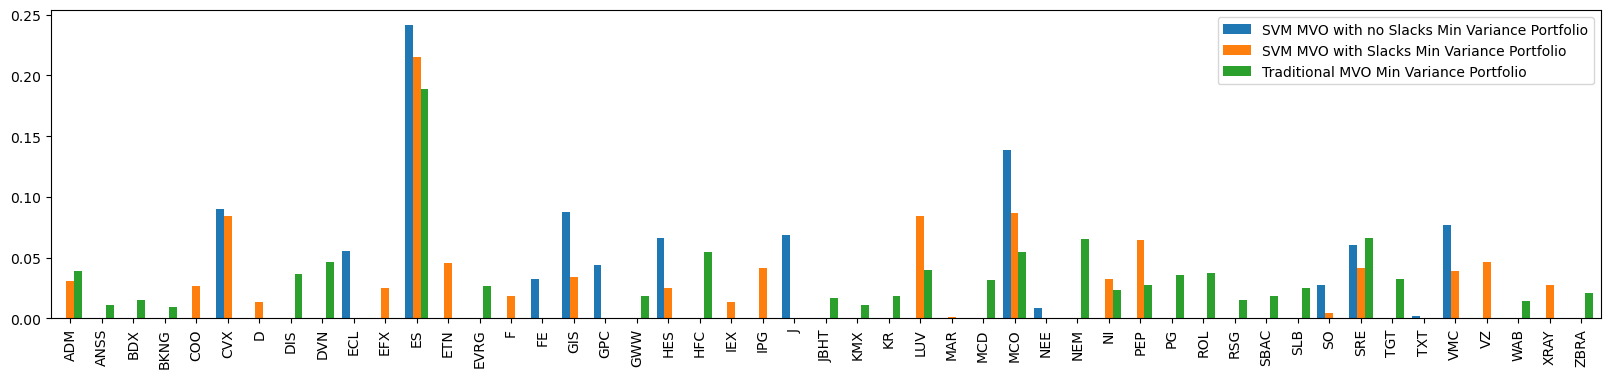

In [12]:
#portfolio comparison
#out = pd.concat([SVM_MVO_Slck.get_results(), SVM_MVO.get_results(), MVO.get_results()], axis = 0)
out = pd.concat([SVM_MVO.get_results(), SVM_MVO_Slck.get_results(), MVO.get_results()], axis = 0)
out[out.columns[(out > 0.001).any(axis = 0)]].transpose()[:-2].plot.bar(figsize = (20,4), width = 0.75);

In [21]:
return_premium = 0.1 #similiar to Costa and Kwon 
#Limit = 0.75/6 #1/6 because Costa and Kwon use 1 for 6 month period. 
T = len(rets.index)

def evaluate_model(rets, forecasts, wrds_svm, return_premium, model_instance, T, N, cols, Limit, lr = 0.05):

  weights = np.zeros([T,N])
  oot_returns = np.zeros(T)
  market = np.zeros(T)
  M = len(cols)
  wis = np.zeros([T,M])
  bias = []
  i = 0 #index for dates
  w_mabs = 0 #initialize
  soln_mods = {}
  for prd in rets.index.to_list()[:T]:
    ret_ = rets.loc[prd][:N]
    cov_, mean_ = forecasts[prd]
    cov = cov_[:N,:N]
    mean = mean_[:N,:]
    tics = list(rets.columns[:N])
    return_premium_temp = return_premium 
    #get the wharton research data for the valid tickers for the month
    wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(prd, level="MonthStart")
    #restrict the wharton research data to the columns of interest
    #modifying WRDS dataset here if required
    Y = wrds_tics.loc[:,cols] # Y matrix in formulation 
    Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
    ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium)
    model_instance.tics = tics
    model_instance.ret_constr = ret_constr
    model_instance.mean_ret = mean
    model_instance.cov = cov
    model_instance.exogenous = Y_
    if i > 0: #not the first trade gets a constraint on turnover
      x_prev = model_instance.x.X

      if model_instance.svm_constr:
        w_mabs = (i/(i+1))*w_mabs + (1/(i+1))*np.abs(model_instance.w.x).mean()
        w_prev = model_instance.w.x

    model_instance.set_model()

    if i > 0: #not the first trade gets a constraint on turnover
      model_instance.define_turnover(x_prev, np.ones_like(x_prev), Limit, 1)

      if model_instance.svm_constr:
        u = model_instance.model.addMVar(M, lb = np.zeros(M), ub = np.ones(M))
        wcon1 = model_instance.model.addConstr(model_instance.w <= w_prev + lr*w_mabs*u , 'iter constraint 1')
        wcon2 = model_instance.model.addConstr(model_instance.w >= w_prev - lr*w_mabs*u , 'iter constraint 2')

    model_instance.model.Params.LogToConsole = 0
    
    model_instance.optimize(cbb = cb)
    k = 1
    while model_instance.model.status == 4:
      #if the model is infeasible the decrease the return constraint
      #we do not have enough turnover the modify the portfolio to achive the 
      #return target... not a great place to be
      return_premium_temp = return_premium - 0.05*k
      ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium_temp)
      model_instance.ret_constr = ret_constr
      model_instance.ret_target[0].rhs = ret_constr
      model_instance.optimize(cbb = cb)
      k = k+1
      #relax the return target bc the turnover constraint isnt allowing it to solve
    #oot_returns[i] = model_instance.evaluate(ret_)
    market[i] = ret_.mean()
    weights[i, :] = model_instance.x.x
    if model_instance.model.IsMIP:
      soln_mods[prd] = [model_instance.model.MIPGap, return_premium_temp]
    else:
      soln_mods[prd] = return_premium_temp
    if model_instance.svm_constr:
      wis[i,:] = model_instance.w.x
      bias.append(model_instance.b.x)
      # if model_instance.w.x >= w_prev + lr*w_mabs  and wcon2.Pi < 10**(-7):
      #   lr = lr/2
    if i + 1 >= T:
      break
    if i%12 == 0:
      print("_"*25)
      print("Iteration ", i)
      print("Percent Complete ", i/T)
    i = i+1
  
  weights = pd.DataFrame(weights, index = rets.index[:T], columns = model_instance.tics)
  oot_returns = pd.Series(oot_returns, index = rets.index[:T])
  market = pd.Series(market, index = rets.index[:T])
  return weights, oot_returns, market, wis, bias, soln_mods

In [ ]:
# svm_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Slck, T, N, cols, 1/6)
# with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/negvol_1by6_Card07.pkl", 'wb') as fp:
#   pkl.dump(svm_results, fp);

# svm_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Slck, T, N, cols, 0.75/6)
# with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/negvol_0_75by6_Card07.pkl", 'wb') as fp:
#   pkl.dump(svm_results, fp);

svm_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Slck, T, N, cols, 1.25/6)
with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/Card05_negvol_1_25by6.pkl", 'wb') as fp:
  pkl.dump(svm_results, fp);


_________________________
Iteration  0
Percent Complete  0.0
_________________________
Iteration  12
Percent Complete  0.04938271604938271
_________________________
Iteration  24
Percent Complete  0.09876543209876543
_________________________
Iteration  36
Percent Complete  0.14814814814814814
_________________________
Iteration  48
Percent Complete  0.19753086419753085
_________________________
Iteration  60
Percent Complete  0.24691358024691357
_________________________
Iteration  72
Percent Complete  0.2962962962962963
_________________________
Iteration  84
Percent Complete  0.345679012345679
_________________________
Iteration  96
Percent Complete  0.3950617283950617
_________________________
Iteration  108
Percent Complete  0.4444444444444444
_________________________
Iteration  120
Percent Complete  0.49382716049382713
_________________________
Iteration  132
Percent Complete  0.5432098765432098
_________________________
Iteration  144
Percent Complete  0.5925925925925926
______

In [ ]:
weights_svm, oot_returns_svm, market_svm, wis_svm, bias_svm, soln_mods_svm = svm_results
print('svm turnover proxy', weights_svm.diff().abs().sum(axis = 1).sum())

svm turnover proxy 50.32524136739624


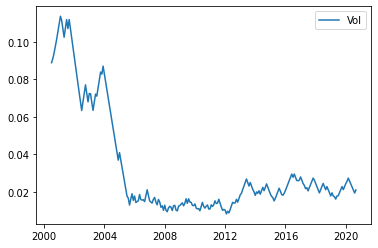

In [ ]:
plt.plot(rets.index[:T], wis_svm);
plt.legend(cols);

### Part 2 Cardinalty Constrined MVO 

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 290 rows, 858 columns and 1716 nonzeros
Model fingerprint: 0xf53e1047
Model has 41041 quadratic objective terms
Model has 286 general constraints
Variable types: 572 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve added 284 rows and 0 columns
Presolve removed 0 rows and 286 columns
Presolve time: 0.04s
Presolved: 574 rows, 572 columns, 1716 nonzeros
Presolved model has 41041 quadratic objective terms
Variable types: 286 continuous, 286 integer (286 binary)
Found heuristic solution: objective 0.0391937

Root relaxation: objective 6.860883e-04, 182 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 

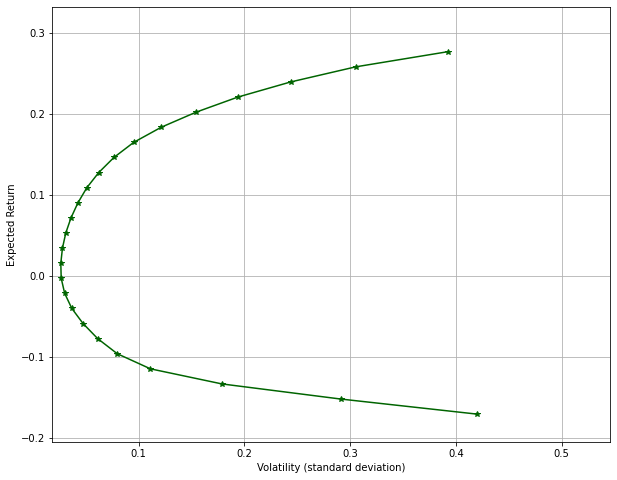

In [ ]:
MVO2 = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, AssetLim,\
             svm_choice = (False, False), print_var_frntr= False, cardinality = True) #define an instance of the class
MVO2.set_model() #set up the model
MVO2.optimize() #find optimal solution
MVO2.model.params.outputflag = 0
mv_ef = MVO2.get_frontier()

In [ ]:

def evaluate_model(rets, forecasts, wrds_svm, return_premium, model_instance, T, N, cols, Limit):
  lr = 0.1 #learning rate for the SVM support vector
  weights = np.zeros([T,N])
  oot_returns = np.zeros(T)
  market = np.zeros(T)
  M = len(cols)
  wis = np.zeros([T,M])
  bias = []
  i = 0 #index for dates
  w_mabs = 0 #initialize
  soln_mods = {}
  for prd in rets.index.to_list()[:T]:
    ret_ = rets.loc[prd][:N]
    cov_, mean_ = forecasts[prd]
    cov = cov_[:N,:N]
    mean = mean_[:N,:]
    tics = list(rets.columns[:N])
    return_premium_temp = return_premium 
    #get the wharton research data for the valid tickers for the month
    wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(prd, level="MonthStart")
    #restrict the wharton research data to the columns of interest
    #modifying WRDS dataset here if required
    Y = wrds_tics.loc[:,cols] # Y matrix in formulation 
    Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
    ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium)
    model_instance.tics = tics
    model_instance.ret_constr = ret_constr
    model_instance.mean_ret = mean
    model_instance.cov = cov
    model_instance.exogenous = Y_
    if i > 0: #not the first trade gets a constraint on turnover
      x_prev = model_instance.x.X

      if model_instance.svm_constr:
        w_mabs = (i/(i+1))*w_mabs + (1/(i+1))*np.abs(model_instance.w.x).mean()
        w_prev = model_instance.w.x

    model_instance.set_model()

    if i > 0: #not the first trade gets a constraint on turnover
      model_instance.define_turnover(x_prev, np.ones_like(x_prev), Limit, 1)

      if model_instance.svm_constr:
        u = model_instance.model.addMVar(M, lb = np.zeros(M), ub = np.ones(M))
        wcon1 = model_instance.model.addConstr(model_instance.w <= w_prev + lr*w_mabs*u + model_instance.epsilon, 'iter constraint 1')
        wcon2 = model_instance.model.addConstr(model_instance.w >= w_prev - lr*w_mabs*u - model_instance.epsilon, 'iter constraint 2')

    model_instance.model.Params.LogToConsole = 0
    
    model_instance.optimize(cbb = cb)
    k = 1
    while model_instance.model.status == 4:
      #if the model is infeasible the decrease the return constraint
      #we do not have enough turnover the modify the portfolio to achieve the
      #return target... not a great place to be
      return_premium_temp = return_premium - 0.05*k
      ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium_temp)
      model_instance.ret_constr = ret_constr
      model_instance.ret_target[0].rhs = ret_constr
      model_instance.optimize(cbb = cb)
      k = k+1
      #relax the return target bc the turnover constraint isnt allowing it to solve
    #oot_returns[i] = model_instance.evaluate(ret_) #noneed for this
    market[i] = ret_.mean()
    weights[i, :] = model_instance.x.x
    if model_instance.model.IsMIP:
      soln_mods[prd] = [model_instance.model.MIPGap, return_premium_temp]
    else:
      soln_mods[prd] = return_premium_temp
    if model_instance.svm_constr:
      wis[i,:] = model_instance.w.x
      bias.append(model_instance.b.x)
      # if model_instance.w.x >= w_prev + lr*w_mabs  and wcon2.Pi < 10**(-7):
      #   lr = lr/2
    if i + 1 >= T:
      break
    if i%12 == 0:
      print("_"*25)
      print("Iteration ", i)
      print("Percent Complete ", i/T)
    i = i+1
  
  weights = pd.DataFrame(weights, index = rets.index[:T], columns = model_instance.tics)
  oot_returns = pd.Series(oot_returns, index = rets.index[:T])
  market = pd.Series(market, index = rets.index[:T])
  return weights, oot_returns, market, wis, bias, soln_mods


In [ ]:
import time
def cb(model, where):
    if where == GRB.Callback.MIPNODE:
        # Get model objective
        obj = model.cbGet(GRB.Callback.MIPNODE_OBJBST)

        # Has objective changed?
        if abs(obj - model._cur_obj) > 1e-8:
            # If so, update incumbent and time
            model._cur_obj = obj
            model._time = time.time()

    # Terminate if objective has not improved in 60s
    if time.time() - model._time > 120:
        model.terminate()
mvo_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, MVO2, T, N, cols, 0.75/6)
with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/Card05__oot_results__turnover0_75by6.pkl", 'wb') as fp:
  pkl.dump(mvo_results, fp);

_________________________
Iteration  0
Percent Complete  0.0
_________________________
Iteration  12
Percent Complete  0.04938271604938271
_________________________
Iteration  24
Percent Complete  0.09876543209876543
_________________________
Iteration  36
Percent Complete  0.14814814814814814
_________________________
Iteration  48
Percent Complete  0.19753086419753085
_________________________
Iteration  60
Percent Complete  0.24691358024691357
_________________________
Iteration  72
Percent Complete  0.2962962962962963
_________________________
Iteration  84
Percent Complete  0.345679012345679
_________________________
Iteration  96
Percent Complete  0.3950617283950617
_________________________
Iteration  108
Percent Complete  0.4444444444444444
_________________________
Iteration  120
Percent Complete  0.49382716049382713
_________________________
Iteration  132
Percent Complete  0.5432098765432098
_________________________
Iteration  144
Percent Complete  0.5925925925925926
______

In [ ]:
mvo_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, MVO2, T, N, cols, 1/6)
with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/Card05__oot_results__turnover1by6.pkl", 'wb') as fp:
  pkl.dump(mvo_results, fp);

_________________________
Iteration  0
Percent Complete  0.0
_________________________
Iteration  12
Percent Complete  0.04938271604938271
_________________________
Iteration  24
Percent Complete  0.09876543209876543
_________________________
Iteration  36
Percent Complete  0.14814814814814814
_________________________
Iteration  48
Percent Complete  0.19753086419753085
_________________________
Iteration  60
Percent Complete  0.24691358024691357
_________________________
Iteration  72
Percent Complete  0.2962962962962963
_________________________
Iteration  84
Percent Complete  0.345679012345679
_________________________
Iteration  96
Percent Complete  0.3950617283950617
_________________________
Iteration  108
Percent Complete  0.4444444444444444
_________________________
Iteration  120
Percent Complete  0.49382716049382713
_________________________
Iteration  132
Percent Complete  0.5432098765432098
_________________________
Iteration  144
Percent Complete  0.5925925925925926
______

In [ ]:
mvo_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, MVO2, T, N, cols, 1.25/6)
with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/Card05__oot_results__turnover1_25by6.pkl", 'wb') as fp:
  pkl.dump(mvo_results, fp);